In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
from sklearn.cluster import KMeans

# center and scale the data
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [3]:
credit= pd.read_csv('CC_GENERAL.csv')
credit.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
CUST_ID                             8950 non-null object
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null int64
CREDIT_LIMIT                        8949 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS            

In [5]:
pandas_profiling.ProfileReport(credit)

Number of variables,18
Number of observations,8950
Total Missing (%),0.2%
Total size in memory,1.2 MiB
Average record size in memory,144.0 B
Numeric,16
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,1


### Null Handling - 

In [6]:
credit.shape[0]-credit.count()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [7]:
#  null value of credit_limit will be filled by median value and minnimum_payemnts with 0's
credit['CREDIT_LIMIT'].fillna(value=credit.CREDIT_LIMIT.median(), inplace = True)
credit['MINIMUM_PAYMENTS'].fillna(value=0, inplace =True)

### Derving new KPI 's 

In [8]:
#1. Monthly Avarage Purchages -
credit['MONTHLY_AVG_PURCHASE'] = credit['PURCHASES']/credit['TENURE']

In [9]:
# 2. Monthly Cash Advance -
credit['MONTHLY_AVG_CASH_ADVANCE'] = credit['CASH_ADVANCE']/credit['TENURE']

In [10]:
# 3. Defining purchase type
#There aree 4 types of purchase behavior - deriving categorical variables based on the behavior
def purchasetype(credit):
    if ((credit.ONEOFF_PURCHASES == 0) & (credit.INSTALLMENTS_PURCHASES == 0)):
        return 'NONE'
    if ((credit.ONEOFF_PURCHASES > 0) & (credit.INSTALLMENTS_PURCHASES == 0)):
        return 'ONE_OFF'
    if ((credit.ONEOFF_PURCHASES > 0) & (credit.INSTALLMENTS_PURCHASES > 0)):
        return 'ONEOFF_INSTALLMENT'
    if ((credit.ONEOFF_PURCHASES == 0) & (credit.INSTALLMENTS_PURCHASES > 0)):
        return 'INSTALLMENTS'

In [11]:
credit['PURCHASE_TYPE']=credit.apply(purchasetype,axis=1 )

In [12]:
#4. LIMIT USAGE ( Lower score implies customers are maintaining their balance properly)
credit['LIMIT_USAGE'] = credit.apply(lambda x: x['BALANCE']/x['CREDIT_LIMIT'],axis =1)


In [13]:
#5. PAYMENT_MINPAYMENT
#The where clause is being used to avoid div by zero error
credit['PAYMENT_MINPAYMENT'] = np.where(credit['MINIMUM_PAYMENTS']== 0, credit['PAYMENTS'], credit['PAYMENTS']/credit['MINIMUM_PAYMENTS'])

In [14]:
credit.isnull().any()

CUST_ID                             False
BALANCE                             False
BALANCE_FREQUENCY                   False
PURCHASES                           False
ONEOFF_PURCHASES                    False
INSTALLMENTS_PURCHASES              False
CASH_ADVANCE                        False
PURCHASES_FREQUENCY                 False
ONEOFF_PURCHASES_FREQUENCY          False
PURCHASES_INSTALLMENTS_FREQUENCY    False
CASH_ADVANCE_FREQUENCY              False
CASH_ADVANCE_TRX                    False
PURCHASES_TRX                       False
CREDIT_LIMIT                        False
PAYMENTS                            False
MINIMUM_PAYMENTS                    False
PRC_FULL_PAYMENT                    False
TENURE                              False
MONTHLY_AVG_PURCHASE                False
MONTHLY_AVG_CASH_ADVANCE            False
PURCHASE_TYPE                       False
LIMIT_USAGE                         False
PAYMENT_MINPAYMENT                  False
dtype: bool

In [15]:
credit=credit.round(2)

In [16]:
credit._get_numeric_data().columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'MONTHLY_AVG_PURCHASE', 'MONTHLY_AVG_CASH_ADVANCE',
       'LIMIT_USAGE', 'PAYMENT_MINPAYMENT'],
      dtype='object')

### Insights from newly dervived KPI's

### Insights
1. Customers with one off and installments are paying their dues
2. Customers with one off and installments do most monthly purchases
3. Customers with no  one off and installmentstake more monthly cash advance
4. Customers with installments have good credit score

Text(0, 0.5, 'payment-minimumpayement ratio')

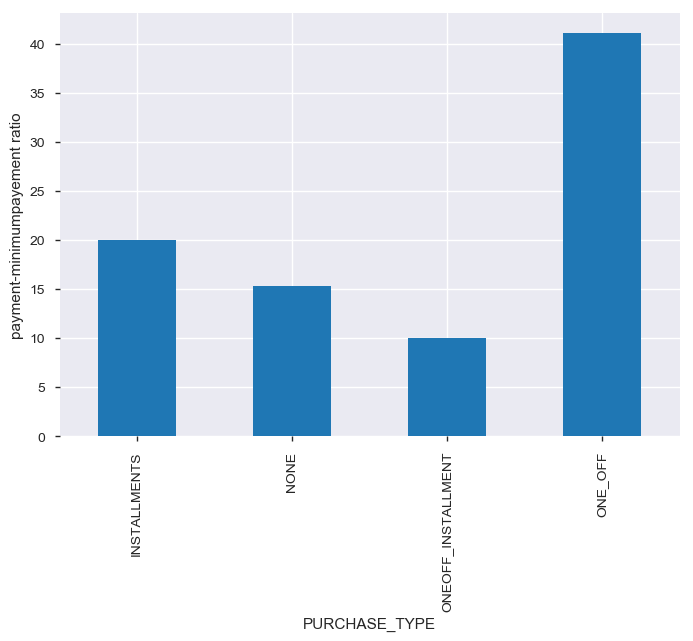

In [17]:
credit.groupby('PURCHASE_TYPE').apply(lambda x: np.mean(x['PAYMENT_MINPAYMENT'])).plot.bar()
plt.ylabel('payment-minimumpayement ratio')

Text(0, 0.5, 'MONTHLY_AVG_PURCHASE')

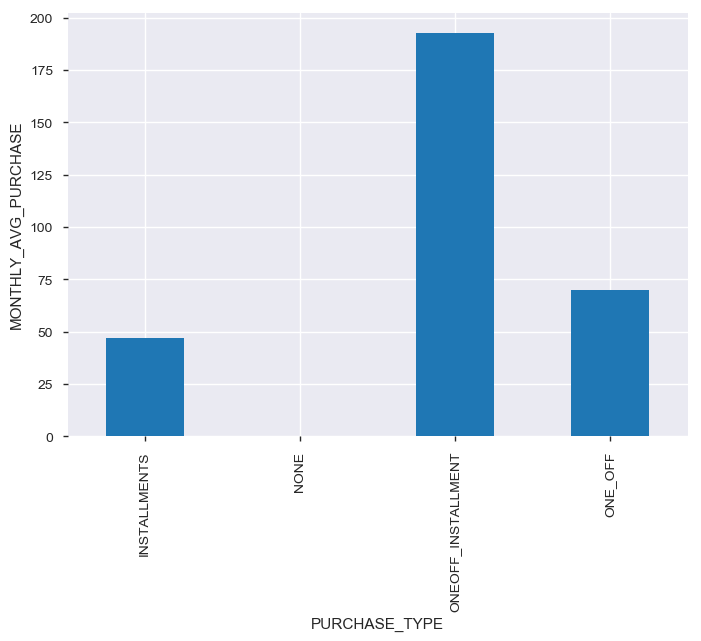

In [18]:
credit.groupby('PURCHASE_TYPE').apply(lambda x: np.mean(x['MONTHLY_AVG_PURCHASE'])).plot.bar()
plt.ylabel('MONTHLY_AVG_PURCHASE')

Text(0, 0.5, 'MONTHLY_AVG_CASH_ADVANCE')

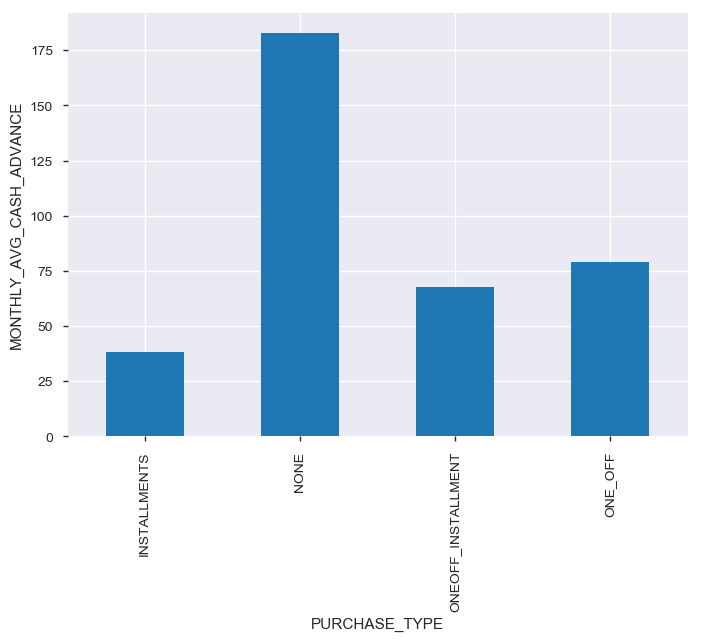

In [19]:
credit.groupby('PURCHASE_TYPE').apply(lambda x: np.mean(x['MONTHLY_AVG_CASH_ADVANCE'])).plot.bar()
plt.ylabel('MONTHLY_AVG_CASH_ADVANCE')

Text(0, 0.5, 'LIMIT_USAGE')

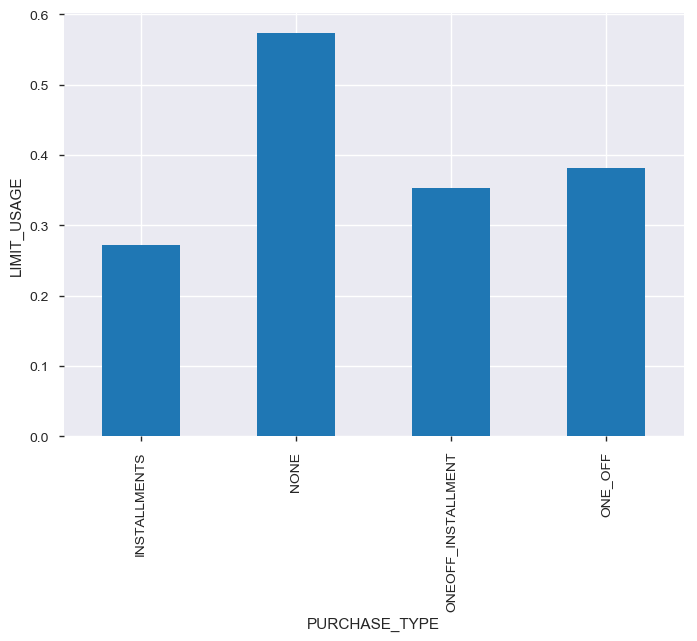

In [20]:
credit.groupby('PURCHASE_TYPE').apply(lambda x: np.mean(x['LIMIT_USAGE'])).plot.bar()
plt.ylabel('LIMIT_USAGE')

In [21]:
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

credit_num=credit._get_numeric_data().apply(lambda x: outlier_capping(x))

C:\Users\arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: clip_upper(threshold) is deprecated, use clip(upper=threshold) instead
  
C:\Users\arnav\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
credit_num.columns


Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'MONTHLY_AVG_PURCHASE', 'MONTHLY_AVG_CASH_ADVANCE',
       'LIMIT_USAGE', 'PAYMENT_MINPAYMENT'],
      dtype='object')

In [23]:
credit_cat=credit.select_dtypes(['object'])
credit_cat.columns

Index(['CUST_ID', 'PURCHASE_TYPE'], dtype='object')

### Dropping cust_id and creating dummies for purchase_type

In [24]:

dummies=pd.get_dummies(credit.PURCHASE_TYPE,prefix='PURCHASE_TYPE',drop_first=True)


In [25]:
credit_merg=pd.concat([credit_num,dummies],axis=1)

In [26]:
credit_merg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 24 columns):
BALANCE                             8950 non-null float64
BALANCE_FREQUENCY                   8950 non-null float64
PURCHASES                           8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
CASH_ADVANCE                        8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null float64
CREDIT_LIMIT                        8950 non-null float64
PAYMENTS                            8950 non-null float64
MINIMUM_PAYMENTS                    8950 non-null float64
PRC_FULL_PAYMENT         

In [27]:
# DROPPING VARIABLE USED IN DERIVING KPI's

credit_new=credit_merg.drop(columns=['BALANCE', 'PURCHASES' ,'PAYMENTS' ,'MINIMUM_PAYMENTS',  'TENURE', 'CASH_ADVANCE' ,'CREDIT_LIMIT'])

In [28]:
credit_new.head()

,BALANCE_FREQUENCY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,MONTHLY_AVG_PURCHASE,MONTHLY_AVG_CASH_ADVANCE,LIMIT_USAGE,PAYMENT_MINPAYMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF_INSTALLMENT,PURCHASE_TYPE_ONE_OFF
0,0.82,0.00,95.4,0.17,0.00,0.08,0.00,0,2.0,0.00,7.95,0.00,0.04,1.45,0,0,0
1,0.91,0.00,0.0,0.00,0.00,0.00,0.25,4,0.0,0.22,0.00,536.91,0.46,3.83,1,0,0
2,1.00,773.17,0.0,1.00,1.00,0.00,0.00,0,12.0,0.00,64.43,0.00,0.33,0.99,0,0,1
3,0.64,1499.00,0.0,0.08,0.08,0.00,0.08,1,1.0,0.00,124.92,17.15,0.22,0.00,0,0,1
4,1.00,16.00,0.0,0.08,0.08,0.00,0.00,0,1.0,0.00,1.33,0.00,0.68,2.77,0,0,1


In [29]:
credit_new.columns

Index(['BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT',
       'MONTHLY_AVG_PURCHASE', 'MONTHLY_AVG_CASH_ADVANCE', 'LIMIT_USAGE',
       'PAYMENT_MINPAYMENT', 'PURCHASE_TYPE_NONE',
       'PURCHASE_TYPE_ONEOFF_INSTALLMENT', 'PURCHASE_TYPE_ONE_OFF'],
      dtype='object')

In [30]:
credit_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
BALANCE_FREQUENCY                   8950 non-null float64
ONEOFF_PURCHASES                    8950 non-null float64
INSTALLMENTS_PURCHASES              8950 non-null float64
PURCHASES_FREQUENCY                 8950 non-null float64
ONEOFF_PURCHASES_FREQUENCY          8950 non-null float64
PURCHASES_INSTALLMENTS_FREQUENCY    8950 non-null float64
CASH_ADVANCE_FREQUENCY              8950 non-null float64
CASH_ADVANCE_TRX                    8950 non-null int64
PURCHASES_TRX                       8950 non-null float64
PRC_FULL_PAYMENT                    8950 non-null float64
MONTHLY_AVG_PURCHASE                8950 non-null float64
MONTHLY_AVG_CASH_ADVANCE            8950 non-null float64
LIMIT_USAGE                         8950 non-null float64
PAYMENT_MINPAYMENT                  8950 non-null float64
PURCHASE_TYPE_NONE                  8950 non-null uint8
PURCHASE_TYPE_ONEOFF_INSTAL

In [31]:
credit_new.corr()

,BALANCE_FREQUENCY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,MONTHLY_AVG_PURCHASE,MONTHLY_AVG_CASH_ADVANCE,LIMIT_USAGE,PAYMENT_MINPAYMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF_INSTALLMENT,PURCHASE_TYPE_ONE_OFF
BALANCE_FREQUENCY,1.000000,0.137787,0.153729,0.233188,0.202909,0.179553,0.193818,0.162651,0.212388,-0.097424,0.166319,0.093894,0.448912,-0.348437,0.010720,0.194298,-0.091032
ONEOFF_PURCHASES,0.137787,1.000000,0.333809,0.349824,0.683709,0.158851,-0.102845,-0.067593,0.630735,0.145922,0.883943,-0.066990,-0.065940,0.142575,-0.265931,0.423637,0.096313
INSTALLMENTS_PURCHASES,0.153729,0.333809,1.000000,0.551624,0.248394,0.634422,-0.162148,-0.111387,0.687538,0.214951,0.700536,-0.105991,-0.090099,0.108444,-0.309136,0.434702,-0.292610
PURCHASES_FREQUENCY,0.233188,0.349824,0.551624,1.000000,0.501554,0.862955,-0.311735,-0.238286,0.642159,0.305791,0.504826,-0.248889,-0.220747,0.063713,-0.663350,0.515609,-0.217887
ONEOFF_PURCHASES_FREQUENCY,0.202909,0.683709,0.248394,0.501554,1.000000,0.142607,-0.113093,-0.081246,0.601359,0.157709,0.607905,-0.106161,-0.097021,0.074234,-0.368199,0.525290,0.202986
PURCHASES_INSTALLMENTS_FREQUENCY,0.179553,0.158851,0.634422,0.862955,0.142607,1.000000,-0.265378,-0.200103,0.593603,0.249980,0.396766,-0.208191,-0.178406,0.057675,-0.498279,0.463434,-0.471850
CASH_ADVANCE_FREQUENCY,0.193818,-0.102845,-0.162148,-0.311735,-0.113093,-0.265378,1.000000,0.880945,-0.150985,-0.253005,-0.144264,0.681296,0.397592,-0.097446,0.378453,-0.095163,-0.025869
CASH_ADVANCE_TRX,0.162651,-0.067593,-0.111387,-0.238286,-0.081246,-0.200103,0.880945,1.000000,-0.096709,-0.201097,-0.097219,0.693157,0.330987,-0.076663,0.285854,-0.051092,-0.022655
PURCHASES_TRX,0.212388,0.630735,0.687538,0.642159,0.601359,0.593603,-0.150985,-0.096709,1.000000,0.179487,0.770418,-0.118669,-0.062716,0.089362,-0.367023,0.552466,-0.178086
PRC_FULL_PAYMENT,-0.097424,0.145922,0.214951,0.305791,0.157709,0.249980,-0.253005,-0.201097,0.179487,1.000000,0.204366,-0.176401,-0.464788,0.158911,-0.203260,0.078273,-0.090101


In [32]:
credit_new.to_csv('credit_new_corr.csv')

###  Standardising data

In [33]:
scalor=StandardScaler()
credit_scaled=scalor.fit_transform(credit_new)

C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\arnav\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [34]:
pd.DataFrame(credit_scaled,columns=credit_new.columns).head()

,BALANCE_FREQUENCY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,PRC_FULL_PAYMENT,MONTHLY_AVG_PURCHASE,MONTHLY_AVG_CASH_ADVANCE,LIMIT_USAGE,PAYMENT_MINPAYMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF_INSTALLMENT,PURCHASE_TYPE_ONE_OFF
0,-0.248514,-0.489121,-0.427513,-0.797242,-0.677221,-0.715675,-0.684016,-0.557505,-0.579714,-0.524666,-0.560473,-0.518323,-0.987127,-0.323571,-0.543690,-0.670193,-0.514625
1,0.135587,-0.489121,-0.568588,-1.220490,-0.677221,-0.916882,0.594617,0.166685,-0.675130,0.227132,-0.621841,2.758750,0.211120,-0.175903,1.839282,-0.670193,-0.514625
2,0.519687,0.215778,-0.568588,1.269205,2.672431,-0.916882,-0.684016,-0.557505,-0.102638,-0.524666,-0.124484,-0.518323,-0.159766,-0.352112,-0.543690,-0.670193,1.943162
3,-1.016715,0.877517,-0.568588,-1.021315,-0.409249,-0.916882,-0.274853,-0.376457,-0.627422,-0.524666,0.342459,-0.413646,-0.473593,-0.413537,-0.543690,-0.670193,1.943162
4,0.519687,-0.474534,-0.568588,-1.021315,-0.409249,-0.916882,-0.684016,-0.557505,-0.627422,-0.524666,-0.611575,-0.518323,0.838773,-0.241671,-0.543690,-0.670193,1.943162


### APLYING PCA

In [35]:
from sklearn.decomposition import PCA

In [36]:
pc = PCA(n_components=17)

In [37]:
pc=pc.fit(credit_scaled)


In [38]:
np.round(pc.explained_variance_ratio_, decimals=4)*100

array([32.73, 16.84, 10.62,  8.99,  6.36,  5.07,  4.41,  3.68,  2.35,
        2.16,  2.1 ,  1.95,  1.11,  0.68,  0.63,  0.2 ,  0.1 ])

In [39]:
np.cumsum(np.round(pc.explained_variance_ratio_, decimals=4)*100)

array([32.73, 49.57, 60.19, 69.18, 75.54, 80.61, 85.02, 88.7 , 91.05,
       93.21, 95.31, 97.26, 98.37, 99.05, 99.68, 99.88, 99.98])

In [103]:
# since 7 components explain 88 percent variation. so selecting 7 components

pc_final=PCA(n_components=7).fit(credit_scaled)

In [104]:
reduced_cr=pc_final.fit_transform(credit_scaled)

In [42]:
reduced_cr.shape

(8950, 7)

In [43]:
credit_scaled.shape

(8950, 17)

In [44]:
column=credit_new.columns

In [45]:
column

Index(['BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT',
       'MONTHLY_AVG_PURCHASE', 'MONTHLY_AVG_CASH_ADVANCE', 'LIMIT_USAGE',
       'PAYMENT_MINPAYMENT', 'PURCHASE_TYPE_NONE',
       'PURCHASE_TYPE_ONEOFF_INSTALLMENT', 'PURCHASE_TYPE_ONE_OFF'],
      dtype='object')

In [105]:
pd.DataFrame(pc_final.components_.T, columns=['PC_' + str(i) for i in range(7)], index=column)

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6
BALANCE_FREQUENCY,0.065107,0.321742,-0.134479,-0.435766,0.033179,-0.301440,0.110789
ONEOFF_PURCHASES,0.276098,0.169545,0.402637,0.032392,-0.247404,-0.112399,-0.000385
INSTALLMENTS_PURCHASES,0.304659,0.118597,-0.190468,0.121227,-0.120614,0.086992,0.459785
PURCHASES_FREQUENCY,0.358829,0.014231,-0.180506,-0.056124,0.318554,0.070172,-0.026502
ONEOFF_PURCHASES_FREQUENCY,0.272760,0.138304,0.388551,-0.089674,0.040379,-0.110954,-0.343831
PURCHASES_INSTALLMENTS_FREQUENCY,0.311247,0.013897,-0.423934,0.033770,0.194189,0.145125,0.103972
CASH_ADVANCE_FREQUENCY,-0.188427,0.447583,0.015769,0.213241,0.199479,-0.005489,-0.020046
CASH_ADVANCE_TRX,-0.157784,0.444205,0.018669,0.256944,0.280289,0.008055,-0.019746
PURCHASES_TRX,0.352798,0.180197,0.025947,0.030160,-0.110934,0.036583,0.122513
PRC_FULL_PAYMENT,0.158272,-0.181893,-0.024444,0.302095,0.203877,-0.733407,0.121553


### Loading Matrix
Loadings=Eigenvectors * sqrt(Eigenvalues)

loadings are the covariances/correlations between the original variables and the unit-scaled components.

In [47]:
Loadings =  pd.DataFrame((pc_final.components_.T * np.sqrt(pc_final.explained_variance_)).T,columns=credit_new.columns).T

In [48]:
Loadings

,0,1,2,3,4,5,6
BALANCE_FREQUENCY,0.153592,0.544474,-0.180728,-0.538673,0.034508,-0.279735,0.095966
ONEOFF_PURCHASES,0.651336,0.286916,0.541108,0.040041,-0.257315,-0.104306,-0.000333
INSTALLMENTS_PURCHASES,0.718715,0.200698,-0.255971,0.149855,-0.125446,0.080728,0.398269
PURCHASES_FREQUENCY,0.846505,0.024083,-0.242583,-0.069378,0.331315,0.065119,-0.022956
ONEOFF_PURCHASES_FREQUENCY,0.643462,0.234047,0.522177,-0.110851,0.041997,-0.102964,-0.297829
PURCHASES_INSTALLMENTS_FREQUENCY,0.734256,0.023517,-0.569729,0.041745,0.201969,0.134675,0.090062
CASH_ADVANCE_FREQUENCY,-0.444513,0.757431,0.021192,0.263599,0.207470,-0.005094,-0.017364
CASH_ADVANCE_TRX,-0.372224,0.751715,0.025090,0.317622,0.291517,0.007475,-0.017104
PURCHASES_TRX,0.832277,0.304941,0.034870,0.037283,-0.115378,0.033949,0.106122
PRC_FULL_PAYMENT,0.373376,-0.307811,-0.032850,0.373435,0.212045,-0.680598,0.105290


In [49]:
Loadings.to_csv("Loadings_new.csv")

### CLUSTERING

In [106]:
km_3=KMeans(n_clusters=3,random_state=123).fit(reduced_cr)
#km3.labels_

km_4=KMeans(n_clusters=4,random_state=123).fit(reduced_cr)


km_5=KMeans(n_clusters=5,random_state=123).fit(reduced_cr)

km_6=KMeans(n_clusters=6,random_state=123).fit(reduced_cr)


km_7=KMeans(n_clusters=7,random_state=123).fit(reduced_cr)


km_8=KMeans(n_clusters=8,random_state=123).fit(reduced_cr)


In [51]:
# Conactenating labels found through Kmeans with data 
credit_merg['cluster_3'] = km_3.labels_
credit_merg['cluster_4'] = km_4.labels_
credit_merg['cluster_5'] = km_5.labels_
credit_merg['cluster_6'] = km_6.labels_
credit_merg['cluster_7'] = km_7.labels_
credit_merg['cluster_8'] = km_8.labels_

In [52]:
km_3.labels_

array([1, 0, 1, ..., 1, 0, 1])

In [53]:
credit_merg.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PAYMENT_MINPAYMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF_INSTALLMENT,PURCHASE_TYPE_ONE_OFF,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,40.90,0.82,95.40,0.00,95.4,0.00,0.17,0.00,0.08,0.00,...,1.45,0,0,0,1,2,3,1,2,7
1,3202.47,0.91,0.00,0.00,0.0,6442.95,0.00,0.00,0.00,0.25,...,3.83,1,0,0,0,0,0,0,1,1
2,2495.15,1.00,773.17,773.17,0.0,0.00,1.00,1.00,0.00,0.00,...,0.99,0,0,1,1,1,2,4,0,3
3,1666.67,0.64,1499.00,1499.00,0.0,205.79,0.08,0.08,0.00,0.08,...,0.00,0,0,1,1,1,2,4,0,3
4,817.71,1.00,16.00,16.00,0.0,0.00,0.08,0.08,0.00,0.00,...,2.77,0,0,1,1,1,2,4,0,3


### SILHOUETTE  COEFFIECIENT

In [54]:
from sklearn import metrics

In [107]:
# calculate SC for K=3 through K=12
k_range = range(3, 12)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(reduced_cr)
    scores.append(metrics.silhouette_score(reduced_cr, km.labels_))

In [108]:
scores

[0.2541113681984228,
 0.30074804654789294,
 0.31419834007125474,
 0.3133187161290959,
 0.3055923913294339,
 0.30472594304573364,
 0.30109378270013926,
 0.30228404630666944,
 0.3044616138706517]

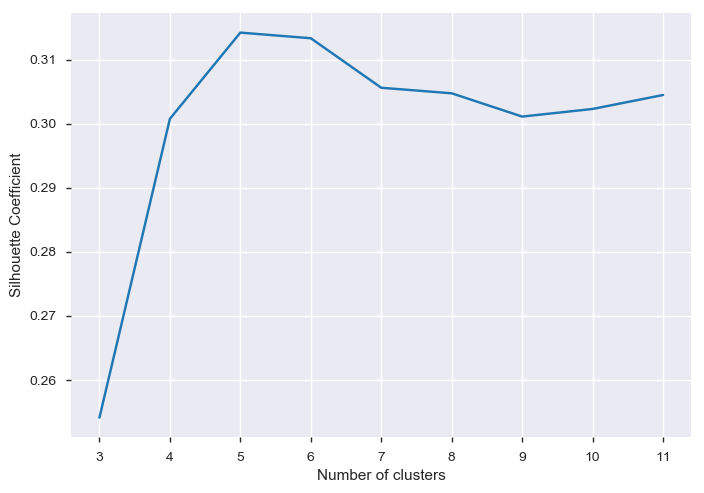

In [109]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

### The solution can be4, 5, 6, based on the SC score. If we take highest SC score, 5  segment solution is best but we have to analyse profilie output as well to finalize solution based on business perspective


### PROFILING

In [58]:
credit_merg.cluster_3.value_counts()/8950

1    0.521453
0    0.308715
2    0.169832
Name: cluster_3, dtype: float64

In [59]:
credit_merg.cluster_3.value_counts()*100/sum(credit_merg.cluster_3.value_counts())

1    52.145251
0    30.871508
2    16.983240
Name: cluster_3, dtype: float64

In [60]:
credit_merg.cluster_3.value_counts()*100/sum(credit_merg.cluster_3.value_counts())

1    52.145251
0    30.871508
2    16.983240
Name: cluster_3, dtype: float64

In [61]:
pd.Series.sort_index(credit_merg.cluster_3.value_counts())

0    2763
1    4667
2    1520
Name: cluster_3, dtype: int64

In [62]:
credit_merg.cluster_3.size

8950

In [63]:
size=pd.concat([pd.Series(credit_merg.cluster_3.size), pd.Series.sort_index(credit_merg.cluster_3.value_counts()), pd.Series.sort_index(credit_merg.cluster_4.value_counts()),
           pd.Series.sort_index(credit_merg.cluster_5.value_counts()), pd.Series.sort_index(credit_merg.cluster_6.value_counts()),
           pd.Series.sort_index(credit_merg.cluster_7.value_counts()), pd.Series.sort_index(credit_merg.cluster_8.value_counts())])

In [64]:
Seg_size=pd.DataFrame(size, columns=['Seg_size'])
Seg_Pct = pd.DataFrame(size/credit_merg.cluster_3.size, columns=['Seg_Pct'])
Seg_size.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_size,8950,2763,4667,1520,2443,1720,3646,1141,1880,1017,...,618,801,368,1801,1772,1625,1125,695,137,1427


In [65]:
Seg_Pct.T

,0,0,1,2,0,1,2,3,0,1,...,5,6,0,1,2,3,4,5,6,7
Seg_Pct,1.0,0.308715,0.521453,0.169832,0.272961,0.192179,0.407374,0.127486,0.210056,0.113631,...,0.06905,0.089497,0.041117,0.201229,0.197989,0.181564,0.125698,0.077654,0.015307,0.159441


In [66]:
# Mean value gives a good indication of the distribution of data. So we are finding mean value for each variable for each cluster
Profling_output = pd.concat([credit_merg.apply(lambda x: x.mean()).T, credit_merg.groupby('cluster_3').apply(lambda x: x.mean()).T, credit_merg.groupby('cluster_4').apply(lambda x: x.mean()).T,
         credit_merg.groupby('cluster_5').apply(lambda x: x.mean()).T, credit_merg.groupby('cluster_6').apply(lambda x: x.mean()).T,
         credit_merg.groupby('cluster_7').apply(lambda x: x.mean()).T, credit_merg.groupby('cluster_8').apply(lambda x: x.mean()).T], axis=1)

Profling_output_final=pd.concat([Seg_size.T, Seg_Pct.T, Profling_output], axis=0)
#Profling_output_final.columns = ['Seg_' + str(i) for i in Profling_output_final.columns]
Profling_output_final.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',
                                'KM7_1', 'KM7_2', 'KM7_3', 'KM7_4', 'KM7_5','KM7_6','KM7_7',
                                'KM8_1', 'KM8_2', 'KM8_3', 'KM8_4', 'KM8_5','KM8_6','KM8_7','KM8_8']

In [67]:
Profling_output_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,...,KM7_6,KM7_7,KM8_1,KM8_2,KM8_3,KM8_4,KM8_5,KM8_6,KM8_7,KM8_8
Seg_size,8950.000000,2763.000000,4667.000000,1520.000000,2443.000000,1720.000000,3646.000000,1141.000000,1880.000000,1017.000000,...,618.000000,801.000000,368.000000,1801.000000,1772.000000,1625.000000,1125.000000,695.000000,137.000000,1427.000000
Seg_Pct,1.000000,0.308715,0.521453,0.169832,0.272961,0.192179,0.407374,0.127486,0.210056,0.113631,...,0.069050,0.089497,0.041117,0.201229,0.197989,0.181564,0.125698,0.077654,0.015307,0.159441
BALANCE,1541.046689,2511.234719,783.638853,2103.015664,2411.589921,1231.313629,867.378836,2296.696768,1873.021332,2220.320933,...,2526.551820,54.241431,3012.266950,1926.628018,1508.734177,1166.427985,1497.800084,4112.454238,22.703323,69.224237
BALANCE_FREQUENCY,0.878230,0.913590,0.823546,0.981855,0.897585,0.824581,0.857965,0.982419,0.877043,0.982252,...,0.983204,0.293446,0.985870,0.891699,0.975999,0.830234,0.976178,0.966863,0.253504,0.706314
PURCHASES,936.229237,127.349084,597.338427,3447.110336,74.969853,639.526279,695.930442,3995.401166,4.600043,4223.322625,...,5346.439595,282.431623,6565.312364,2.492254,637.738617,639.446978,2315.970578,542.089022,458.737810,521.715592
ONEOFF_PURCHASES,536.493774,89.202128,295.035307,2090.936854,41.499906,639.580890,205.361402,2499.043127,0.196165,2663.900629,...,3369.247184,150.234032,4178.323043,0.000000,185.476089,639.504782,1392.161982,341.109393,189.157153,46.930420
INSTALLMENTS_PURCHASES,384.498368,38.190992,302.713653,1265.114516,33.519750,0.000000,490.885988,1375.636576,4.450128,1426.231202,...,1762.948336,132.284357,2034.378421,2.540533,452.730847,0.000000,918.513293,197.737281,269.580657,475.197730
CASH_ADVANCE,935.920994,2324.666845,212.701817,632.078304,2270.063330,590.272170,271.560740,723.356347,1426.428533,474.654997,...,527.358660,304.864373,583.957733,1458.948532,472.153228,463.479637,344.577147,4938.654688,389.156835,49.678648
PURCHASES_FREQUENCY,0.490217,0.096069,0.577632,0.938283,0.063459,0.316180,0.715787,0.945504,0.009085,0.947738,...,0.953495,0.246542,0.950462,0.004603,0.697257,0.317058,0.918987,0.325324,0.428248,0.672733
ONEOFF_PURCHASES_FREQUENCY,0.202177,0.047615,0.156385,0.623730,0.022718,0.315983,0.114632,0.694601,0.000223,0.710049,...,0.738625,0.052322,0.758886,0.000000,0.105006,0.316849,0.598996,0.162604,0.060219,0.023917


In [68]:
Profling_output_final.to_csv('Profiling_output.csv')

### SEGMENTATION CLUSTERING PROFILING OUTPUT

In [74]:
#Key Performance variables - dropping variables that are used in deriving new KPI
col_kpi = ['Seg_size','Seg_Pct','PURCHASES_TRX','MONTHLY_AVG_PURCHASE','CASH_ADVANCE_TRX','MONTHLY_AVG_CASH_ADVANCE','LIMIT_USAGE','PAYMENT_MINPAYMENT','PURCHASE_TYPE_ONEOFF_INSTALLMENT','PURCHASE_TYPE_NONE','PURCHASE_TYPE_ONE_OFF','CREDIT_LIMIT']

In [75]:
# cluster 4,5,6
cluster= ['Overall','KM4_1', 'KM4_2', 'KM4_3', 'KM4_4','KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5','KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5','KM6_6',]
                                
                                
                                

In [76]:
segmentation_cluster=Profling_output_final.loc[col_kpi,cluster]
segmentation_cluster

,Overall,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6
Seg_size,8950.000000,2443.000000,1720.000000,3646.000000,1141.000000,1880.000000,1017.000000,1716.000000,3559.000000,778.000000,1760.000000,949.000000,727.000000,914.000000,1439.000000,3161.000000
Seg_Pct,1.000000,0.272961,0.192179,0.407374,0.127486,0.210056,0.113631,0.191732,0.397654,0.086927,0.196648,0.106034,0.081229,0.102123,0.160782,0.353184
PURCHASES_TRX,14.151385,1.201392,6.224134,13.977924,54.382892,0.120213,56.371563,5.897733,14.656226,8.762211,0.166477,4.216017,9.041265,58.683676,6.698061,16.612626
MONTHLY_AVG_PURCHASE,80.556217,6.869529,57.366779,60.263832,338.127161,0.397596,357.113667,53.636824,63.454777,50.346686,0.626528,26.009631,51.495560,377.084036,59.148846,72.124340
CASH_ADVANCE_TRX,3.079330,7.404830,1.893023,0.911958,2.531989,4.221277,1.588987,1.350816,0.772127,16.634961,4.449432,0.505796,17.063274,1.594092,1.708826,0.926289
MONTHLY_AVG_CASH_ADVANCE,84.921108,208.331555,53.003994,24.077085,63.223492,129.438756,41.033534,38.382525,20.605872,431.577428,132.848811,22.965441,443.745541,42.153658,47.029565,23.925596
LIMIT_USAGE,0.386000,0.579230,0.365198,0.284084,0.329299,0.567814,0.313127,0.339685,0.282484,0.617609,0.616028,0.018872,0.610743,0.309661,0.412196,0.326602
PAYMENT_MINPAYMENT,6.665068,5.137046,6.418814,6.385500,11.201281,5.462422,11.817110,7.016746,6.232213,4.040900,2.669977,24.176510,4.128294,12.485680,3.725879,3.870601
PURCHASE_TYPE_ONEOFF_INSTALLMENT,0.309944,0.058535,0.000000,0.424849,0.948291,0.001064,0.940020,0.000000,0.441697,0.313625,0.002841,0.089568,0.319120,0.936543,0.000000,0.504904
PURCHASE_TYPE_NONE,0.228156,0.835858,0.000000,0.000000,0.000000,0.952128,0.000000,0.000000,0.000000,0.323907,0.938636,0.160169,0.327373,0.000000,0.000000,0.000000


In [77]:
segmentation_cluster.to_csv('segmentation_cluster_analysis_creditcard1.csv')

### 4 cluster solution behavior

In [79]:
kpi = ['PURCHASES_TRX','MONTHLY_AVG_PURCHASE','CASH_ADVANCE_TRX','MONTHLY_AVG_CASH_ADVANCE','LIMIT_USAGE','PAYMENT_MINPAYMENT','PURCHASE_TYPE_ONEOFF_INSTALLMENT','PURCHASE_TYPE_NONE','PURCHASE_TYPE_ONE_OFF','CREDIT_LIMIT']

In [80]:
credit_merg.groupby('cluster_4')[kpi].apply(lambda x: x.mean()).T

cluster_4,0,1,2,3
PURCHASES_TRX,1.201392,6.224134,13.977924,54.382892
MONTHLY_AVG_PURCHASE,6.869529,57.366779,60.263832,338.127161
CASH_ADVANCE_TRX,7.404830,1.893023,0.911958,2.531989
MONTHLY_AVG_CASH_ADVANCE,208.331555,53.003994,24.077085,63.223492
LIMIT_USAGE,0.579230,0.365198,0.284084,0.329299
PAYMENT_MINPAYMENT,5.137046,6.418814,6.385500,11.201281
PURCHASE_TYPE_ONEOFF_INSTALLMENT,0.058535,0.000000,0.424849,0.948291
PURCHASE_TYPE_NONE,0.835858,0.000000,0.000000,0.000000
PURCHASE_TYPE_ONE_OFF,0.044208,1.000000,0.000000,0.040316
CREDIT_LIMIT,4391.410835,4265.630901,3712.157518,7401.358457


In [81]:
# segment distribution
credit_merg.cluster_4.value_counts()*100/sum(credit_merg.cluster_4.value_counts())

2    40.737430
0    27.296089
1    19.217877
3    12.748603
Name: cluster_4, dtype: float64

Text(0.5, 0, 'PC_1')

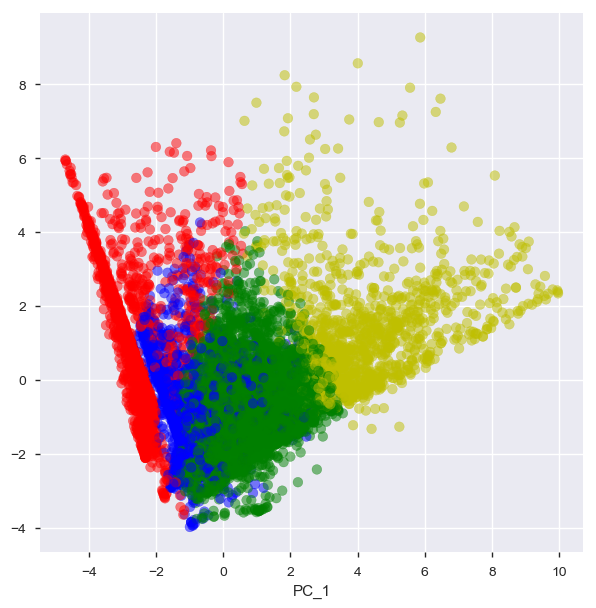

In [82]:
color_map={0:'r', 1:'b', 2:'g', 3:'y'}
label_color = [color_map[l] for l in km_4.labels_]
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=label_color,cmap='Spectral',alpha=0.5)
plt.xlabel('PC_0')
plt.xlabel('PC_1')

### cluste 5 solution behavior

In [83]:
credit_merg.cluster_5.value_counts()*100/sum(credit_merg.cluster_5.value_counts())

3    39.765363
0    21.005587
2    19.173184
1    11.363128
4     8.692737
Name: cluster_5, dtype: float64

In [84]:
credit_merg.groupby('cluster_5')[kpi].apply(lambda x: x.mean()).T

cluster_5,0,1,2,3,4
PURCHASES_TRX,0.120213,56.371563,5.897733,14.656226,8.762211
MONTHLY_AVG_PURCHASE,0.397596,357.113667,53.636824,63.454777,50.346686
CASH_ADVANCE_TRX,4.221277,1.588987,1.350816,0.772127,16.634961
MONTHLY_AVG_CASH_ADVANCE,129.438756,41.033534,38.382525,20.605872,431.577428
LIMIT_USAGE,0.567814,0.313127,0.339685,0.282484,0.617609
PAYMENT_MINPAYMENT,5.462422,11.817110,7.016746,6.232213,4.040900
PURCHASE_TYPE_ONEOFF_INSTALLMENT,0.001064,0.940020,0.000000,0.441697,0.313625
PURCHASE_TYPE_NONE,0.952128,0.000000,0.000000,0.000000,0.323907
PURCHASE_TYPE_ONE_OFF,0.000000,0.048181,0.955711,0.000000,0.237789
CREDIT_LIMIT,3608.333335,7462.881023,4154.303700,3722.218688,6805.912596


Text(0.5, 0, 'PC_1')

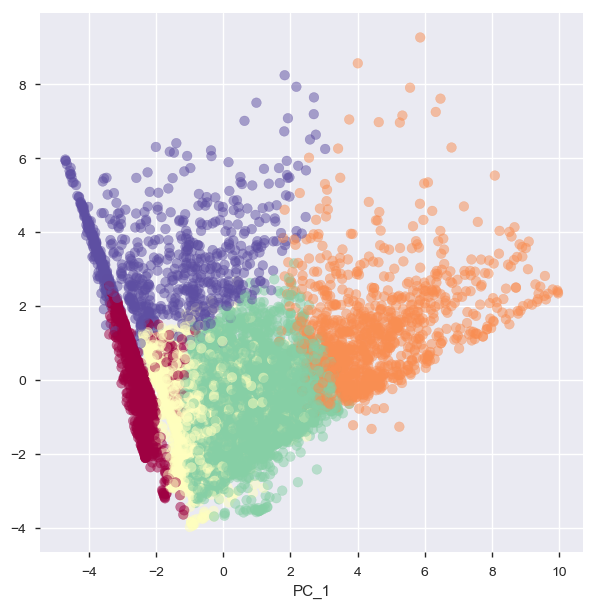

In [85]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1],c=km_5.labels_, cmap='Spectral',alpha=0.5)
plt.xlabel('PC_0')
plt.xlabel('PC_1')

### cluster 6 solution behavior

In [86]:
credit_merg.cluster_6.value_counts()*100/sum(credit_merg.cluster_6.value_counts())

5    35.318436
0    19.664804
4    16.078212
1    10.603352
3    10.212291
2     8.122905
Name: cluster_6, dtype: float64

In [87]:
credit_merg.groupby('cluster_6')[kpi].apply(lambda x: x.mean()).T

cluster_6,0,1,2,3,4,5
PURCHASES_TRX,0.166477,4.216017,9.041265,58.683676,6.698061,16.612626
MONTHLY_AVG_PURCHASE,0.626528,26.009631,51.495560,377.084036,59.148846,72.124340
CASH_ADVANCE_TRX,4.449432,0.505796,17.063274,1.594092,1.708826,0.926289
MONTHLY_AVG_CASH_ADVANCE,132.848811,22.965441,443.745541,42.153658,47.029565,23.925596
LIMIT_USAGE,0.616028,0.018872,0.610743,0.309661,0.412196,0.326602
PAYMENT_MINPAYMENT,2.669977,24.176510,4.128294,12.485680,3.725879,3.870601
PURCHASE_TYPE_ONEOFF_INSTALLMENT,0.002841,0.089568,0.319120,0.936543,0.000000,0.504904
PURCHASE_TYPE_NONE,0.938636,0.160169,0.327373,0.000000,0.000000,0.000000
PURCHASE_TYPE_ONE_OFF,0.000000,0.236038,0.228336,0.050328,0.999305,0.000000
CREDIT_LIMIT,3642.623108,3746.827650,6953.713893,7661.816193,4131.064503,3819.984245


Text(0.5, 0, 'PC_1')

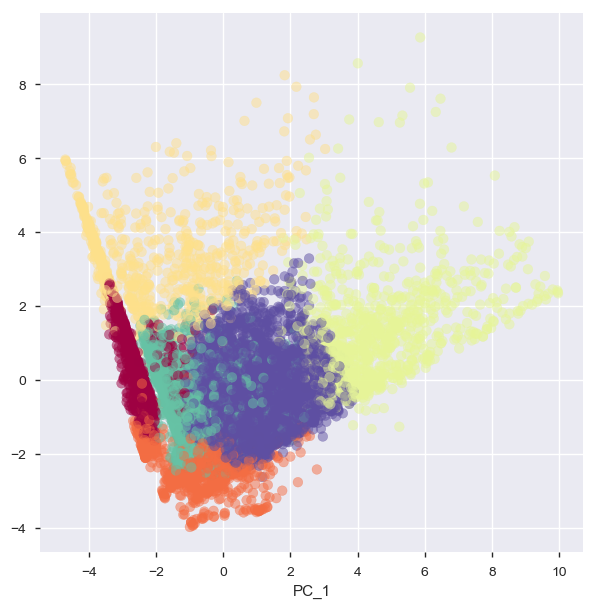

In [88]:
plt.figure(figsize=(7,7))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1],c=km_6.labels_, cmap='Spectral',alpha=0.5)
plt.xlabel('PC_0')
plt.xlabel('PC_1')

### Based on segment distribution, profiling and SC scoring  best  solution is for 5 category segmentation

1. cluster 1 -- It is 21 % of total customer base and customer have  low monthly purchase, but high monthly cash advance and poor credit score, This group is inclined to No purchases of any type
2. cluster 2--  It is  11 % of total customer base and customer have  high monthly purchase, low monthly cash advance and good credit score.This group is doing BOTH   one off  and installment purchases
3. cluster 3: -- 19 % of customer base. this group has   monthly purchase between customer 1  and 2  and  monthly cash advace and crdit score in comparision to cluster 2.  customers of this group are doing mostly one_off  purchases.
4. cluster 4-It is 40 % of total customer base . This group  has best limit usage (lowest) and doing moderate one off and installment purchase.
5. cluster 5 --It is 9 % of total customer base . this group has lower monthly purchase than cluster 1 but higher cash advance than cluster 1. customer are inclined to No or one off purchases

